notes on 2020.1.21:
- 23.5 k cases: rain coverage >= 10%, median threat score: 0.53
- 8.1 k cases: rain coverage >= 20%, median threat score: 0.61
- sampling 1 k cases from 23.5 casese for quick evalucation of parameter tuning

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta
import pandas as pd
import joblib
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data0 = pd.read_csv(csv_path)

/Users/jiang/github_all/rainymotion/docs/notebooks


In [2]:
np.random.seed(3)  # only valid for once
select = np.random.choice(23508, 100).astype(np.int16)
select.sort()
print(data0.loc[select, "threat"].median())

0.5378013431239785


In [10]:
%%time
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h

modela = models.Dense60()  
# default method is "DIS"
# default advection is "constant-vector"

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)

a_threat = []
per_threat = []

for i in select:  
    dt =     datetime.strptime(data0.loc[i,"datetime"], '%Y-%m-%d %H:%M:%S')
    dt_now = dt + timedelta(seconds = time_step)
    dt_12  = dt + timedelta(seconds = time_step * 13)
    yday_str = dt.strftime('%Y_%m_%d')    
    yday_now = dt_now.strftime('%Y_%m_%d')
    yday_12 =  dt_12.strftime('%Y_%m_%d')

    if yday_str not in daily_database:
        daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib"))
    if yday_12 not in daily_database:
        daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) 
    
    inputs[0,:,:] = daily_database[yday_str][int(dt.hour*12     + (dt.minute)/5)]/10.0   # back to original scale
    inputs[1,:,:] = daily_database[yday_now][int(dt_now.hour*12 + (dt_now.minute)/5)]/10.0
    gt_in_60_min =   daily_database[yday_12][int(dt_12.hour*12  + (dt_12.minute)/5)]/10.0
    modela.input_data = inputs
    a_threat.append(metrics.CSI(gt_in_60_min, modela.run(), threshold = threshold)) 
    per_threat.append(metrics.CSI(gt_in_60_min, inputs[1,:,:], threshold = threshold)) 
print(np.median(a_threat))
print(np.median(per_threat))
# Wall time: 1 min

0.5391066629046685
0.473375868031846
CPU times: user 5min 12s, sys: 23.8 s, total: 5min 36s
Wall time: 1min 23s


## convert to panda dataframe and do data analysis

In [14]:
data = data0.loc[select,:]
print(np.median(a_threat))
print(np.median(per_threat))

0.5747434297119545
0.565739694787068
0.47855578033363066


In [15]:
modelb.advection

'semi-lagrangian'

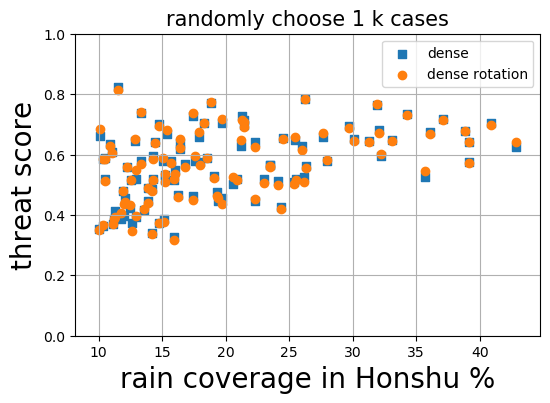

In [17]:
plt.figure(dpi=100)
plt.scatter(data.coverage, a_threat, marker = 's', label = "dense")
plt.scatter(data.coverage, b_threat, marker = 'o',label = "dense rotation")
plt.legend()
plt.title("randomly choose 1 k cases",fontsize= 15)
plt.xlabel("rain coverage in Honshu %",fontsize= 20)
plt.ylabel("threat score",fontsize= 20)
plt.ylim([0,1])
plt.grid()
plt.show()

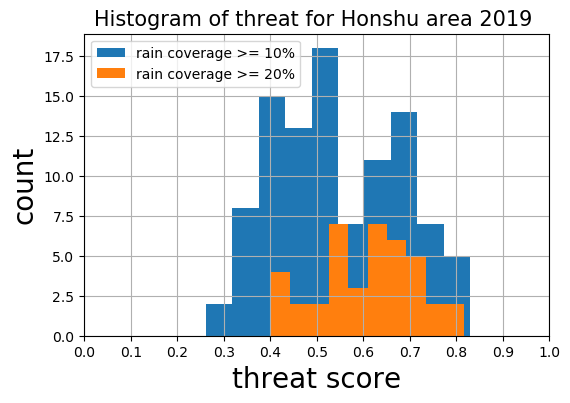

In [27]:
plt.figure(dpi = 100)
plt.hist(data.threat_new,10, label = "rain coverage >= 10%")
plt.hist(data.threat_new[data.coverage >= 20],10, label = "rain coverage >= 20%")
plt.legend()
plt.title("Histogram of threat for Honshu area 2019 ",fontsize= 15)
plt.xlabel("threat score",fontsize= 20)
plt.ylabel("count",fontsize= 20)
plt.xticks(np.linspace(0,1,11))
plt.xlim([0,1])
plt.grid()
plt.show()